# Examine Streamgage Turbidity

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrahnis/nb-streamgage/blob/main/Streamgage-05--Turbidity.ipynb)

## Setup and imports

In [1]:
# if the notebook is running in colab we'll get the data from github
HOST_IS_COLAB = 'google.colab' in str(get_ipython())

if HOST_IS_COLAB:
    path = 'https://github.com/mrahnis/nb-streamgage/blob/main'
    params = '?raw=true'
else:
    path = '.'
    params = ''

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

favorites = {'01576516':'east branch',
         '015765185':'west branch',
         '015765195':'mainstem',
         '01576521':'mainstem-historical'}

gage = '015765195'

In [3]:
# s = pd.read_parquet('{}/data/nwis_{}_instantaneous_all.parquet{}'.format(path, gage, params))

In [4]:
df0 = pd.read_parquet('{}/data/lang_{}_instantaneous_turbidity.parquet{}'.format(path, gage, params))
df1 = pd.read_parquet('{}/data/nwis_{}_instantaneous_all.parquet{}'.format(path, gage, params))

# make datetime the index
df0.set_index('datetime', inplace=True)

# concatenate Langland and NWIS turbidity series
s = pd.concat([df0['63680'], df1['63680']])

## Plot rolling quantiles

This makes a plot of rolling quantiles to give a sense of when extended periods of high turbidity occured. The period in days defines the rolling window size which, in 15 minute periods, is `days * 24 * 4` periods long. The resulting line represents the level of the given quantile within the rolling window. 

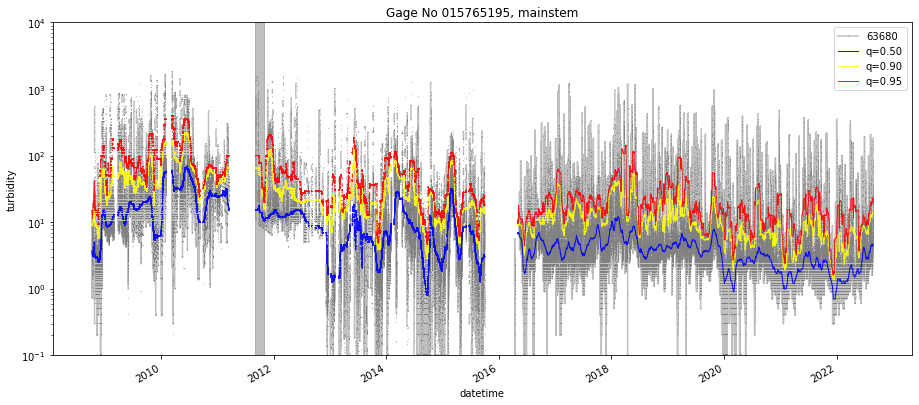

In [5]:
from datetime import datetime
import matplotlib.dates as mdates

# set up the rolling window sizes
days = 30
min_days = 3

periods = days * 24 * 4
min_periods = min_days * 24 * 4

# show the values on a log-axis
logy = True

fig = plt.figure(figsize=(15.4,6.8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Gage No {}, {}'.format(gage, favorites[gage]))
ax.set_ylabel('turbidity')
ax.set_ylim(0.1, 10000)
s.plot(ax=ax, logy=logy, linestyle=None, marker=',', color='gray', alpha=0.5)

q50 = s.rolling(periods, min_periods=min_periods, center=True).quantile(0.5, interpolation='lower')
q90 = s.rolling(periods, min_periods=min_periods, center=True).quantile(0.9, interpolation='lower')
q95 = s.rolling(periods, min_periods=min_periods, center=True).quantile(0.95, interpolation='lower')

q50.plot(ax=ax, logy=logy, linestyle='-', linewidth=1, color='blue', alpha=0.9, label='q=0.50')
q90.plot(ax=ax, logy=logy, linestyle='-', linewidth=1, color='yellow', alpha=0.9, label='q=0.90')
q95.plot(ax=ax, logy=logy, linestyle='-', linewidth=1, color='red', alpha=0.9, label='q=0.95')
ax.legend()

# plot a rectangle showing the duration of construction
start = mdates.date2num(datetime(2011,8,31))
end = mdates.date2num(datetime(2011,10,31))
width = end - start

ymin, ymax = ax.get_ylim()
rect = plt.Rectangle((start, ymin), width, ymax-ymin, color='gray', alpha=0.5, zorder=1)
ax.add_patch(rect)

## Load weather data

Historical weather data is available from NOAA Climate Data Online. This data is from the station at the Lancaster Filtration Plant (GHCND:USC00364763):
https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USC00364763/detail

We load the CSV file downloaded from NOAA, convert the strings representing dates into localized datetime objects and set that as the index.

In [6]:
wx = pd.read_csv('./data/noaa-daily-3080214.csv')

wx['DATETIME'] = pd.to_datetime(wx['DATE']).map(lambda x: x.tz_localize('EST'))
wx.set_index('DATETIME', inplace=True)

## Plot the air temperature series and water turbidity

The code for this plot does a couple interesting things.

For the upper panel it creates a boolean mask for any days where the maximum air temperature, TMAX, is less than zero. Then it uses that mask as the `where` condition when we `fill_between` the daily TMAX and TMIN series. This highlights days when temperature never rose above freezing. We could go further and find runs of consecutive days during which temperature never rose above freezing, but this gives a basic sense of which winters were the coldest.

The lower panel uses axis sharing and axis twinning to plot two series, log-turbidity and precipitation, with different y-axes while sharing the same x-axis as the plot in the upper panel.

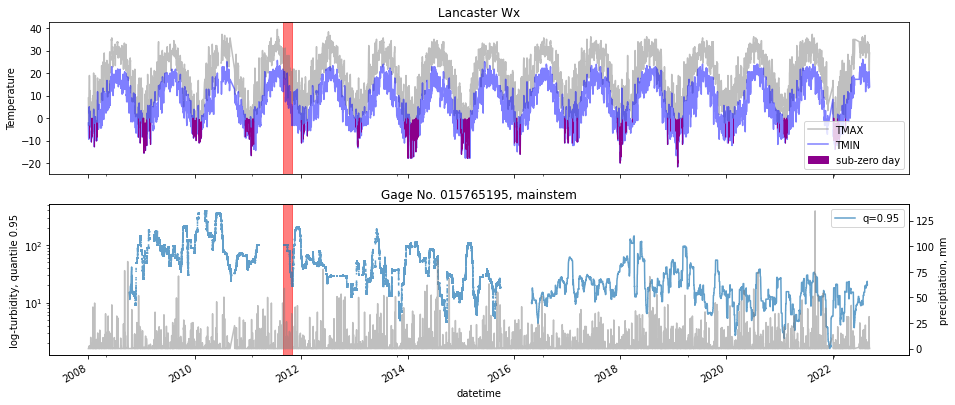

In [7]:
# make a boolean (True/False) mask
mask = (wx['TMAX'] <= 0).rename('SUBZERO_DAYS')

fig = plt.figure(figsize=(15.4,6.8))
ax_temp = fig.add_subplot(2,1,1)

# plot the daily air temperature extremes
ax_temp.set_title('Lancaster Wx')
ax_temp.set_ylabel('Temperature')
wx['TMAX'].plot(ax=ax_temp, linestyle='-', marker=None, alpha=0.5, color='gray', label='TMAX')
wx['TMIN'].plot(ax=ax_temp, linestyle='-', marker=None, alpha=0.5, color='blue', label='TMIN')
plt.fill_between(wx.index, wx['TMAX'], wx['TMIN'], where=mask, color='darkmagenta', alpha=1, zorder=2.5, label='sub-zero day')

ymin, ymax = ax_temp.get_ylim()
ax_temp.add_patch(
    plt.Rectangle((start, ymin), width, ymax-ymin, color='red', alpha=0.5, zorder=1)
)
ax_temp.legend()

# plot the stream log-turbidity with daily precipitation
ax = fig.add_subplot(2, 1, 2, sharex=ax_temp)
ax.set_title('Gage No. {}, {}'.format(gage, favorites[gage]))
ax.set_ylabel('log-turbidity, quantile 0.95')
q95.plot(ax=ax, logy=True, linestyle='-', alpha=0.7, label='q=0.95')
axp = ax.twinx()
axp.set_ylabel('preciptiation, mm')
wx['PRCP'].plot(ax=axp, linestyle='-', marker=None, alpha=0.5, color='gray', label='precipitation')

ymin, ymax = ax.get_ylim()
ax.add_patch(
    plt.Rectangle((start, ymin), width, ymax-ymin, color='red', alpha=0.5, zorder=1)
)
ax.legend()